In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
# Main function you call from the other script
# Note that you have to tell the other notebook that it should use this notebook, something with % blabla AnalyseFootScan.ipynb
# In case you run it with all pictures better comment the plots...
def analyseFootScan(image):

    # convert to RGB 
    # Note: By default OpenCV used BGR
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    print('Visualization of foot scan in RGB and grayscale:')
    
    # visualization of color image and gray-scale
    fig1 = plt.figure(1)
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(122)
    plt.imshow(img_gray, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

    # visualization of all channels separately
    # fig2 = plt.figure(2)
    # plt.subplot(131)
    # plt.imshow(img[:,:,2], cmap = 'gray')
    # plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    # plt.subplot(132)
    # plt.imshow(img[:,:,1], cmap = 'gray')
    # plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    # plt.subplot(133)
    # plt.imshow(img[:,:,0], cmap = 'gray')
    # plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    # plt.show()
    
    # extract foot region from grayscale image
    # alternatively one could use a separated channel, i.e. red, green or blue
    foot_region = extractFootRegion(img_gray)
    
    # clean grayscale image using extracted foot region
    img_gray_clean = img_gray
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    for y in range(0, h): # loop over image
        for x in range(0, w):
            if foot_region[y, x] == 0:
                img_gray_clean[y, x] = 255

    print('Visualization of cleaned grayscale:')
    
    # visualization of clean grayscale image
    fig1 = plt.figure(1)
    plt.subplot(111)
    plt.imshow(img_gray_clean, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

    # extract foot dimensions
    length, width = extractFootDimensions(img_gray_clean)
    
    return length, width

In [3]:
def extractFootRegion(img_gray):
    
    # get binary image via threshold
    ret,img_binary = cv2.threshold(img_gray,245,255,0)
    img_binary = cv2.bitwise_not(img_binary) # to have the foot region white and the background black

    # remove artifacts by opening and closing
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(20,20))
    img_clean = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, element)
    img_clean = cv2.morphologyEx(img_clean, cv2.MORPH_CLOSE, element)

    # removed artifacts 
    # Note: Just for visualization, opening deletes some pixels and closing adds pixels
    img_artifacts_removed = img_binary - img_clean
    img_artifacts_added = img_clean - img_binary

    print('Visualization of artifact removal and resulting over-approximative foot region:')
        
    fig1 = plt.figure(1)
    plt.subplot(151)
    plt.imshow(img_gray, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(152)
    plt.imshow(img_binary, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(153)
    plt.imshow(img_clean, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(154)
    plt.imshow(img_artifacts_removed, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(155)
    plt.imshow(img_artifacts_added, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
    # ------------ TODO ------------
    # 1. count number of objects in img_clean
    # 2. if more than one object only keep the one with the largest area
    # ------------------------------
    
    return img_clean

In [4]:
# Note: By now also toes are considered for width! 
def extractFootDimensions(img_gray_clean):
    
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    
    ret,img_tresh = cv2.threshold(img_gray_clean,245,255,0)
    img_tresh = cv2.bitwise_not(img_tresh)
    
    print('Visualization of considered foot region for extraxting dimensions:')
    
    # visualization of binary image of foot region based on threshold
    fig1 = plt.figure(1)
    plt.subplot(111)
    plt.imshow(img_tresh, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
    row_sum = np.sum(img_tresh, axis=1)
    column_sum = np.sum(img_tresh, axis=0)

    upper_limit = -1
    for y in range(0, h): # loop over image columns
        if row_sum[y] > 0:
            upper_limit = y
            #print(upper_limit)
            break

    lower_limit = -1
    for y in range(h-1,-1,-1):
        if row_sum[y] > 0:
            lower_limit = y
            #print(lower_limit)
            break

    left_limit = -1
    for x in range(0,w):
        if column_sum[x] > 0:
            left_limit = x
            #print(left_limit)
            break

    right_limit = -1
    for x in range(w-1,-1,-1):
        if column_sum[x] > 0:
            right_limit = x
            #print(right_limit)
            break

    foot_length_dots = lower_limit - upper_limit
    foot_length_inch = foot_length_dots/72.0
    foot_length_cm = foot_length_inch * 2.54

    foot_width_dots = right_limit - left_limit
    foot_width_inch = foot_width_dots/72.0
    foot_width_cm = foot_width_inch * 2.54

    print("Foot length is " + str(round(foot_length_cm,2)) + " cm.")
    print("Foot width is " + str(round(foot_width_cm,2)) + " cm.")
    
    return round(foot_length_cm,2), round(foot_width_cm,2)

Visualization of foot scan in RGB and grayscale:


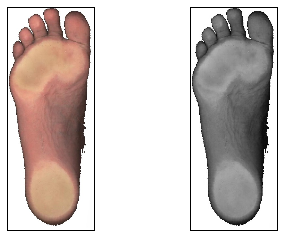

Visualization of artifact removal and resulting over-approximative foot region:


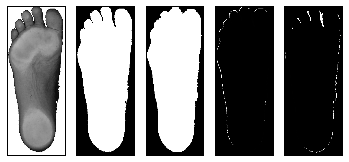

Visualization of cleaned grayscale:


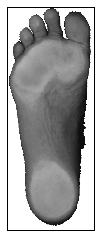

Visualization of considered foot region for extraxting dimensions:


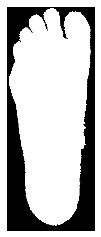

Foot length is 27.59 cm.
Foot width is 10.27 cm.


In [7]:
# This is the call that has to be added in the other notebook:

image = cv2.imread("D.JPG") # load image
length, width = analyseFootScan(image)